# Predicting hospital length-of-stay (LOS) at time of admission


## Table of Contents

* [1. __Prepare Problem__](#heading--1)
  * [1.1. Load libraries](#heading--1-1)
  * [1.2. Load dataset](#heading--1-2)
  * [1.3. Describe the data](#heading--1-3)
  * [1.4. Load the data](#heading--1-4)
* [2. __Preparing Data__](#heading--2) 
  * [2.1. Data Transforms](#heading--2-1)
      * [2.1.1. Encoding effects](#heading--2-1-1)
      * [2.1.2. data scaling](#heading--2-1-2)
  * [2.2. Feature Selection](#heading--2-2)   
* [3. __Evaluate Algorithms__](#heading--3) 
  * [3.1. Spot Check Algorithms](#heading--3-1)




<div id="heading--1"/>

## 1.Prepare Problem

<div id="heading--1-1"/>

### 1.1. Load libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import gc
from category_encoders             import *
#from utils                         import Automatic_Outlier_Removal, residual_plot
from scipy                         import stats
from numpy                         import set_printoptions
from pandas.plotting               import scatter_matrix
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.preprocessing         import PowerTransformer
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import mean_absolute_error
from sklearn.metrics               import r2_score
from sklearn.metrics               import mean_squared_error
from sklearn.linear_model          import LinearRegression
from sklearn.linear_model          import HuberRegressor
from sklearn.linear_model          import Lars
from sklearn.linear_model          import LassoLars
from sklearn.linear_model          import PassiveAggressiveRegressor
from sklearn.linear_model          import RANSACRegressor
from sklearn.linear_model          import Lasso
from sklearn.linear_model          import Ridge
from sklearn.linear_model          import ElasticNet
from sklearn.tree                  import DecisionTreeRegressor
from sklearn.tree                  import ExtraTreeRegressor
from sklearn.linear_model          import SGDRegressor
from sklearn.linear_model          import TheilSenRegressor
from sklearn.neighbors             import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.svm                   import SVR
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import f_regression
from sklearn.feature_selection     import RFE
from sklearn.feature_selection     import mutual_info_regression
from sklearn.decomposition         import PCA
#from sklearn.pipeline              import Pipeline
from imblearn.pipeline             import Pipeline
from imblearn.pipeline             import make_pipeline
from sklearn.model_selection       import GridSearchCV
from sklearn.compose               import ColumnTransformer
from sklearn.ensemble              import BaggingRegressor
from sklearn.ensemble              import RandomForestRegressor
from sklearn.ensemble              import GradientBoostingRegressor
from sklearn.ensemble              import ExtraTreesRegressor
from sklearn.ensemble              import AdaBoostRegressor
from xgboost                       import XGBRegressor


pd.reset_option('all')
%matplotlib inline


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



* __Some re-usable functions__

In [3]:
# evaluate a model
def evaluate_model(X, y, model):
   # define the model cross-validation configuration
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the pipeline using cross validation and calculate MAE
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # convert MAE scores to positive values
    scores = np.absolute(scores)
    return scores

def evaluate_models(models, names, results, X, y):
    print('Comparison of different encoding algorithm')
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        scores = evaluate_model(X, y, models[i])
        results.append(scores)
        # summarize and store
        print('>MAE for %s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
    # plot the results
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)

    plt.boxplot(results, labels=names, showmeans=True)
    ax.set_xticklabels(names)
    plt.show()

<div id="heading--1-2"/>

### 1.2. Load dataset

In [5]:
data_path = '../data_2021-may-15/'
#data.to_csv(data_path+'@admission_clean_LOS.csv', index=False)
df =  pd.read_csv(data_path+'@admission_clean_LOS.csv', low_memory=False)
print('Dimensions of the dataset:\n',df.shape)

Dimensions of the dataset:
 (669469, 64)


In [6]:
print('Total number of unique rows in data is {}'.format(len(df.drop_duplicates( keep = 'first'))))
print('\nDimensions of the dataset after handling columns with high MisVal :\n\n -->',df.shape,'\n\n')
print('Total Number of remained missing values --> {}'.format(df.isna().sum().sum()))

Total number of unique rows in data is 143188

Dimensions of the dataset after handling columns with high MisVal :

 --> (669469, 64) 


Total Number of remained missing values --> 0


<div id="heading--1-3"/>

### 1.3. Describe the data

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(2))

,visit,urno,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,icd10,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,pmet,charl3,elective,outlier,frail2,LOS,state,sa4,ICD10AM,age_range
0,897520,1226958.0,0,MTC,HME,EAD,0,-1,6.0,1.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.4,25,1.5,119,4.7,75,152,7.0,7.0,3.0,9.0,0,1,0,0,0.0,D50.9,0,1,0,0,0,0,0,N/L,0,1,1,1,0,0.061319,VIC,206.0,Blood,7
1,962323,438854.0,0,10W,HWL,EAD,0,-1,6.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.4,25,1.5,120,9.0,90,250,7.0,7.0,2.0,9.0,0,0,0,0,-1.0,M50.0,0,0,0,0,0,0,0,N/S,0,0,1,0,0,7.208461,VIC,206.0,Muscular,7


* __Categorical features__

In [6]:
#df.info()
with pd.option_context( 'display.max_columns', None):
    display(df.select_dtypes(include='object').head(3))

,cward,csource,cadmitclass,ecomplaintcode,icd10,unitcode,state,ICD10AM
0,MTC,HME,EAD,-1,D50.9,N/L,VIC,Blood
1,10W,HWL,EAD,-1,M50.0,N/S,VIC,Muscular
2,10W,HWL,EAD,-1,M50.0,N/S,VIC,Muscular


In [7]:
df.select_dtypes(include='object').describe()

,cward,csource,cadmitclass,ecomplaintcode,icd10,unitcode,state,ICD10AM
count,669469,669469,669469,669469,669469,669469,669469,669469
unique,32,9,4,137,4266,37,9,18
top,DP1,HME,EAD,-1,Z51.1,ESS,VIC,Circulatory
freq,114277,390861,409817,444183,64456,116933,603668,88956


* Drop ICD10 column (We checked and realized that It will reduce the performance)

In [7]:
df.drop(['ICD10AM','icd10', 'visit','urno'], axis=1, inplace = True)

* __Separate X and Y__

In [8]:
X, y = df.iloc[:, df.columns != 'LOS'], df['LOS']

* __Separate categorical and Numerical features__

In [9]:
# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

# separate categorical columns into two groups (oneHot encoding and Target encoding candidates)
one_hot_cols , target_enc_cols = [], []
for col in categorical_ix:
    if len(df[col].unique()) < 10:
        one_hot_cols.append(col)
    else:
        target_enc_cols.append(col)
print(categorical_ix)

Index(['cward', 'csource', 'cadmitclass', 'ecomplaintcode', 'unitcode',
       'state'],
      dtype='object')


<div id="heading--2"/>

## 2.Prepare Data


<div id="heading--2-1"/>

### 2.1. Data Transforms

<div id="heading--2-1-1"/>

#### 2.1.1. Encoding effects

In [11]:

col_transformers = []
pca_list = ['PolynomialEncoder', 'HelmertEncoder', 'HashingEncoder', 'BackwardDifferenceEncoder', 'SumEncoder', 'PolynomialEncoder']
encoders = {'TargetEncoder':           TargetEncoder(),
            'GLMMEncoder':             GLMMEncoder(),
            'BaseNEncoder':            BaseNEncoder(),
            'BinaryEncoder':           BinaryEncoder(),
            'CatBoostEncoder':         CatBoostEncoder(),
            'GLMMEncoder':             GLMMEncoder(),            
            'JamesSteinEncoder':       JamesSteinEncoder(),
            'LeaveOneOutEncoder':      LeaveOneOutEncoder(),
            'MEstimateEncoder':        MEstimateEncoder(),            
            'OrdinalEncoder':          OrdinalEncoder(),            
           }
# try each encoding method available, which works on multiclass problems
for encoder_name, encoder in encoders.items():
    # define the data preparation for the columns
    t = [('cat',   encoder, categorical_ix )]
    col_transformers.append(( ColumnTransformer(transformers=t, remainder='passthrough') , encoder_name) )
   
#col_transform3 = ColumnTransformer(transformers=t3, remainder='drop')

In [12]:
# define models to test
def get_models():
    models, names = list(), list()
    model = LinearRegression()#
    # loop over different models with different encodings
    for i in range(len(col_transformers)):
        trans_name = col_transformers[i][1]
        ColTrans   = col_transformers[i][0]
        # append models
        models.append(Pipeline(steps=[('prep',ColTrans),('t1', MinMaxScaler()), ('m', model)]))
        names.append(trans_name)         
    # return Models and their corresponding names    
    return models, names

Comparison of different encoding algorithm
>MAE for TargetEncoder 2.245 (0.013)
>MAE for GLMMEncoder 2.244 (0.013)
>MAE for BaseNEncoder 2.553 (0.048)
>MAE for BinaryEncoder 2.553 (0.048)
>MAE for CatBoostEncoder 2.243 (0.015)
>MAE for JamesSteinEncoder 2.294 (0.011)
>MAE for LeaveOneOutEncoder 2.248 (0.013)
>MAE for MEstimateEncoder 2.245 (0.013)
>MAE for OrdinalEncoder 2.685 (0.015)


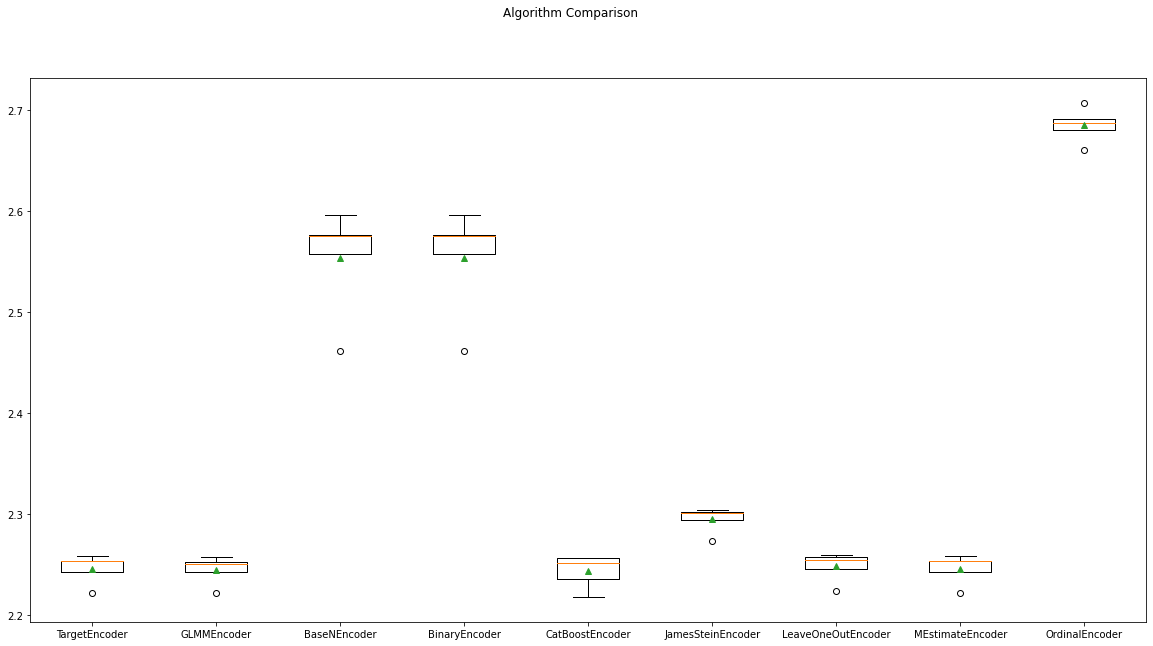

In [13]:
#from imblearn.pipeline   import Pipeline
# define models
models, names = get_models()
results = list()
evaluate_models(models, names, results, X, y)

* __Finding TargetEncoder best parameters__

In [14]:
#from sklearn.pipeline import Pipeline
ColTrans = ColumnTransformer(transformers=[('targetencoder',   TargetEncoder(), categorical_ix )], remainder='passthrough') 
pipeline = Pipeline(steps=[('columntransformer',ColTrans),('t1', MinMaxScaler()), ('m', LinearRegression())])
# define grid
grid = dict()
grid['columntransformer__targetencoder__smoothing'] = [ 100.0, 120.0, 125.0]
grid['columntransformer__targetencoder__min_samples_leaf'] = [17,18,19]
# define search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error',verbose= 1,refit = True, cv=3, n_jobs=-1)
# perform the search
results = search.fit(X,y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
MAE: -2.257
Config: {'columntransformer__targetencoder__min_samples_leaf': 17, 'columntransformer__targetencoder__smoothing': 120.0}


* __Best encoding algorithm__

In [15]:
smoothing = results.best_params_['columntransformer__targetencoder__smoothing']
min_samples_leaf = results.best_params_['columntransformer__targetencoder__min_samples_leaf']
Best_Enc = ColumnTransformer(transformers=[('cat',   TargetEncoder(smoothing=smoothing,min_samples_leaf=min_samples_leaf), categorical_ix )], remainder='passthrough') 

In [10]:
Best_Enc = ColumnTransformer(transformers=[('cat',   TargetEncoder(smoothing=120,min_samples_leaf=18), categorical_ix )], remainder='passthrough') 

<div id="heading--2-1-2"/>

#### 2.1.2. data scaling 

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
# get modeling pipelines to evaluate
def get_models():
    models, names = list(), list()
    model = LinearRegression()
    # normalize
    models.append(Pipeline([('prep',Best_Enc),('s',MinMaxScaler()), ('m',model)]))
    names.append('norm')
    # standardize
    models.append(Pipeline([('prep',Best_Enc),('s',StandardScaler()), ('m',model)]))
    names.append('std')
    # quantile
    models.append(Pipeline([('prep',Best_Enc),('s',QuantileTransformer(n_quantiles=100, output_distribution='normal')), ('m',model)]))
    names.append('quan')
    # discretize
    models.append(Pipeline([('prep',Best_Enc),('s',KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')), ('m',model)]))
    names.append('kbins')
    # pca
    models.append(Pipeline([('prep',Best_Enc),('s',PCA(n_components=7)), ('m',model)]))
    names.append('pca')
    # svd
    models.append(Pipeline([('prep',Best_Enc),('s',TruncatedSVD(n_components=7)), ('m',model)]))
    names.append('svd')
    return models,names 

Comparison of different encoding algorithm
>MAE for norm 2.245 (0.014)
>MAE for std 2.246 (0.014)
>MAE for quan 2.409 (0.012)
>MAE for kbins 2.257 (0.018)
>MAE for pca 3.370 (0.017)
>MAE for svd 3.379 (0.012)


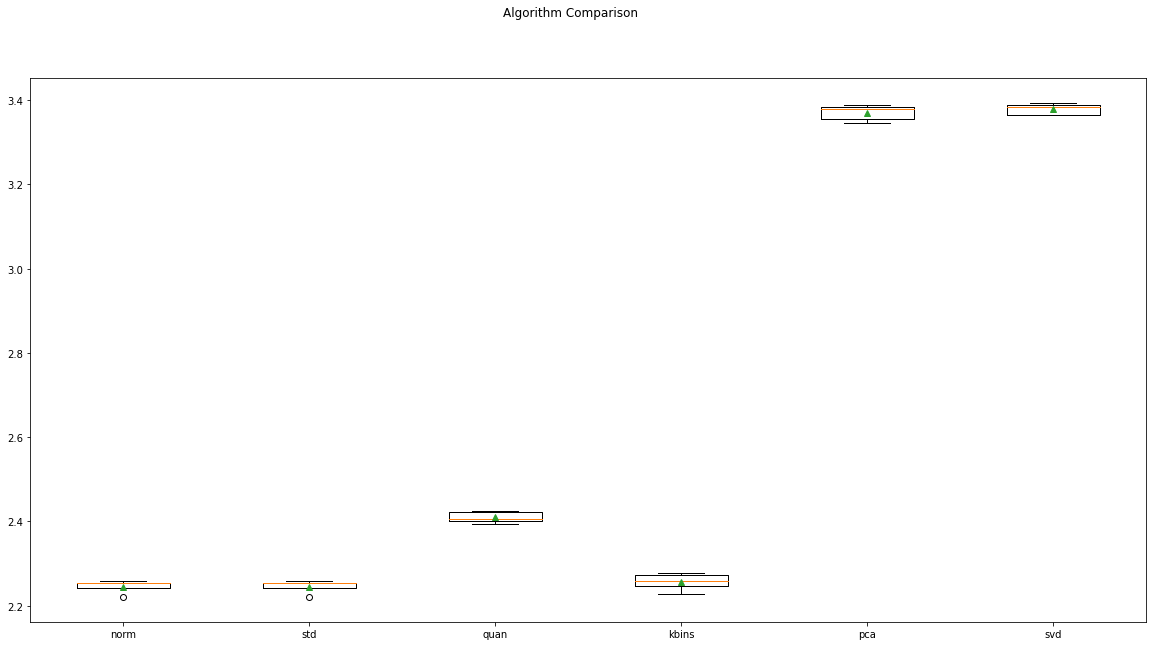

In [18]:
# define models
models, names = get_models()
results = list()
evaluate_models(models, names, results, X, y)

In [11]:
Best_scaler = StandardScaler()

<div id="heading--2-2"/>

### 2.2. Feature Selection

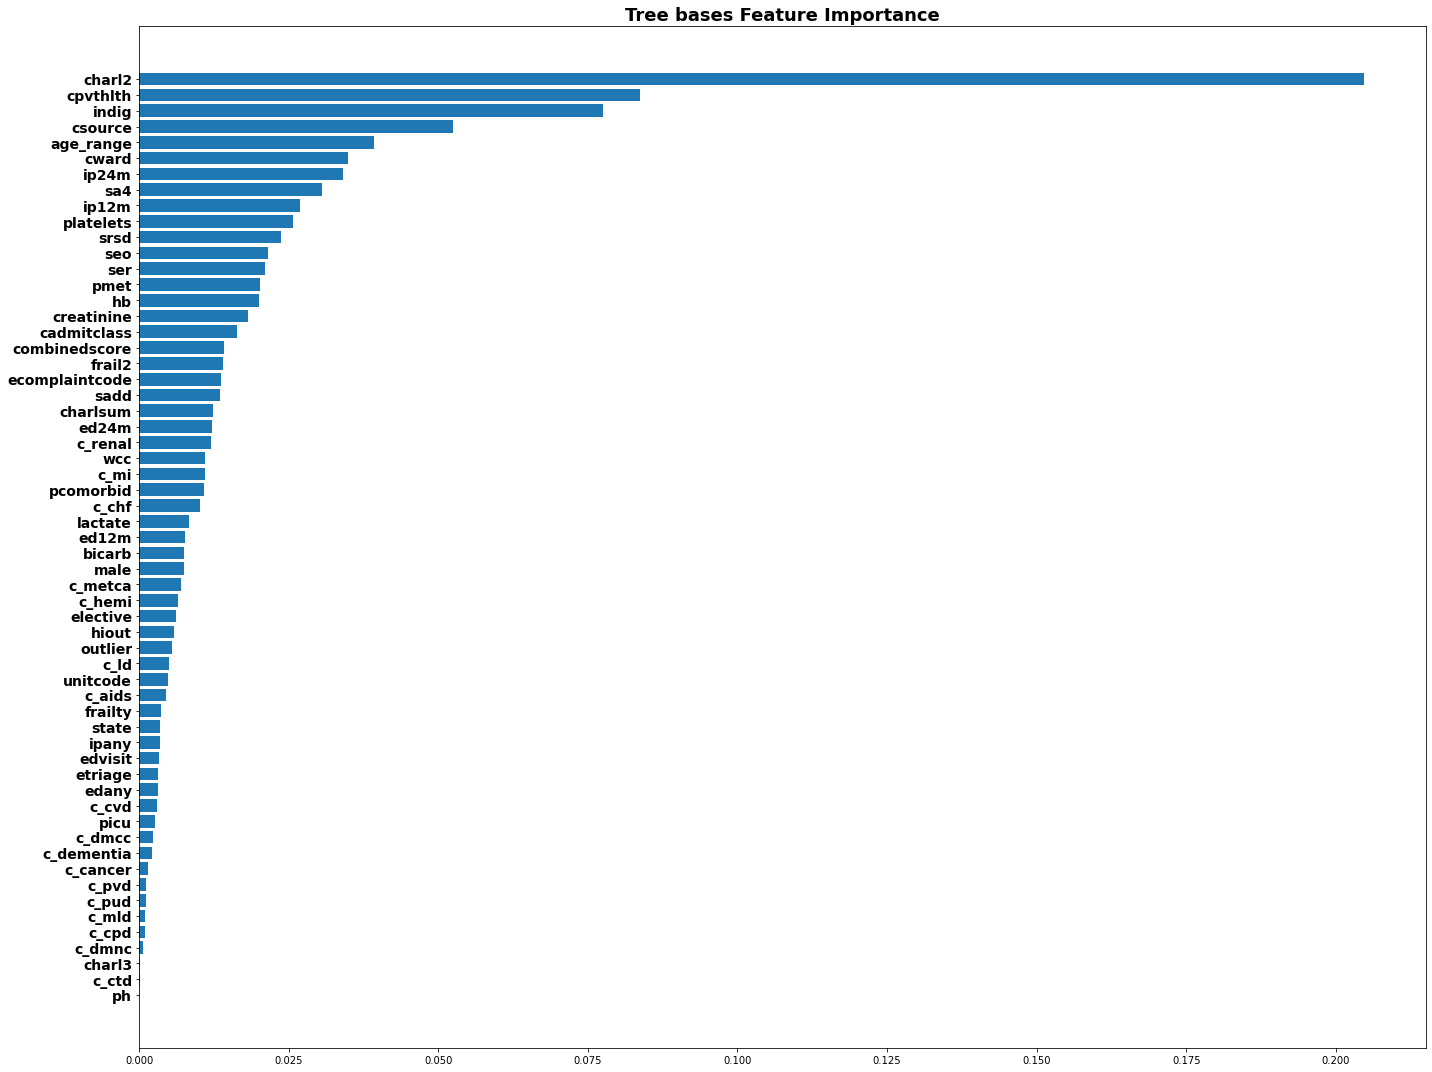

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
LOS Features importance,charl2,cpvthlth,indig,csource,age_range,cward,ip24m,sa4,ip12m,platelets,srsd,seo,ser,pmet,hb,creatinine,cadmitclass,combinedscore,frail2,ecomplaintcode,sadd,charlsum,ed24m,c_renal,wcc,c_mi,pcomorbid,c_chf,lactate,ed12m,bicarb,male,c_metca,c_hemi,elective,hiout,outlier,c_ld,unitcode,c_aids,frailty,state,ipany,edvisit,etriage,edany,c_cvd,picu,c_dmcc,c_dementia,c_cancer,c_pvd,c_pud,c_mld,c_cpd,c_dmnc,charl3,c_ctd,ph


10474

In [14]:
cols = list(df.drop('LOS', axis=1).columns)
plt.rcParams['figure.figsize'] = (20.0, 15.0)

def plot_importance(indices, feature_importances, title):    
    sorted_idx = indices[::-1]
    feature_names = np.array(cols)[sorted_idx].tolist()
    y_ticks  = np.arange(0, len(feature_names)) 
    fig, ax = plt.subplots()
    ax.barh(y_ticks,feature_importances[sorted_idx], align='center')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names, weight = 'bold', fontsize=14)
    ax.set_title(title, weight = 'bold', fontsize=18)
    fig.tight_layout()
    #plt.savefig('Fimportance.png')
    plt.show()
    
# apply encoding on categorical features and then scale the be in standard form (zero mean and unit variance)
X_trans = Best_Enc.fit_transform(X, y)
X_trans = Best_scaler.fit_transform(X_trans)

Num_of_Features = len(cols)


# define the model
model = ExtraTreeRegressor(max_depth= None, max_features= 0.7, min_samples_leaf= 1, min_samples_split= 2)
# fit the model
model.fit(X_trans, y)
# get importance
importance = - model.feature_importances_
indices_tree = np.argsort(importance)
selected_features_names = np.array(cols)[indices_tree][0:Num_of_Features]
plot_importance(indices_tree, -importance, 'Tree bases Feature Importance')
mv_df = pd.DataFrame({'LOS Features importance':np.array(selected_features_names)})
with pd.option_context('display.max_columns', None): 
    display(mv_df.T)

'''#------------------------ Mutual Information Statistics. (mutual_info_regression) -----------------------------------
# Univariate Selection   
test = SelectKBest(score_func=mutual_info_regression, k=Num_of_Features)
fit = test.fit(X_trans, y)
# summarize scores
set_printoptions(precision=3)
importance = -fit.scores_
indices_mutual = np.argsort(importance)
selected_features_names = np.array(cols)[indices_mutual][0:Num_of_Features]
plot_importance(indices_mutual, -importance, 'Mutual Information Statistics')'''

gc.collect()
 

* __find best number of features__

In [21]:
best_score = -np.inf
for ind in range(40,X.shape[1]+1):
    X_ = X[selected_features_names.tolist()[0:ind]]
    new_cat_ix = [cat for cat in categorical_ix if cat in X_.columns.tolist()]
    Best_Enc = ColumnTransformer(transformers=[('cat',   TargetEncoder(), new_cat_ix )], remainder='passthrough') 
    pipeline = Pipeline(steps=[('prep',Best_Enc),('t1', Best_scaler), ('m', LinearRegression())])
    
    
    # evaluate model
    scores = cross_val_score(pipeline, X_, y, scoring="neg_mean_absolute_error", cv=10, n_jobs=-1, error_score='raise')
    # report pipeline performance
    print('MAE of top %s: %.4f (%.4f)' % (str(ind), np.mean(scores), np.std(scores)))
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_params = ind
  
print('Best MAE: %.3f' % best_score)
print('Best Config: %s' % best_params)   
gc.collect()

MAE of top 40: -2.2452 (0.0717)
MAE of top 41: -2.2454 (0.0711)
MAE of top 42: -2.2439 (0.0711)
MAE of top 43: -2.2430 (0.0725)
MAE of top 44: -2.2442 (0.0724)
MAE of top 45: -2.2442 (0.0725)
MAE of top 46: -2.2445 (0.0724)
MAE of top 47: -2.2432 (0.0725)
MAE of top 48: -2.2452 (0.0744)
MAE of top 49: -2.2459 (0.0745)
MAE of top 50: -2.2454 (0.0744)
MAE of top 51: -2.2457 (0.0744)
MAE of top 52: -2.2464 (0.0748)
MAE of top 53: -2.2519 (0.0743)
MAE of top 54: -2.2521 (0.0743)
MAE of top 55: -2.2527 (0.0742)
MAE of top 56: -2.2528 (0.0743)
MAE of top 57: -2.2527 (0.0744)
MAE of top 58: -2.2526 (0.0744)
MAE of top 59: -2.2527 (0.0744)
Best MAE: -2.243
Best Config: 43


207

* __Top feature selection__

In [22]:
top_features = selected_features_names[0:best_params].tolist()

* __Multivariate Plots__

In [56]:
categorical_ix_new = [cat for cat in categorical_ix if cat in top_features[0:30]]
Best_Enc = ColumnTransformer(transformers=[('cat',   TargetEncoder(smoothing=120,min_samples_leaf=18), categorical_ix_new )], remainder='passthrough') 
print()
X__ = X[top_features[0:30]]
T1          = Best_Enc.fit_transform(X__, y)
T1         = pd.DataFrame(T1)
T1.columns = X[top_features[0:30]].columns
T1['LOS']  = df.LOS
T1         = T1[ ['LOS'] + [ col for col in T1.columns if col != 'LOS' ] ]

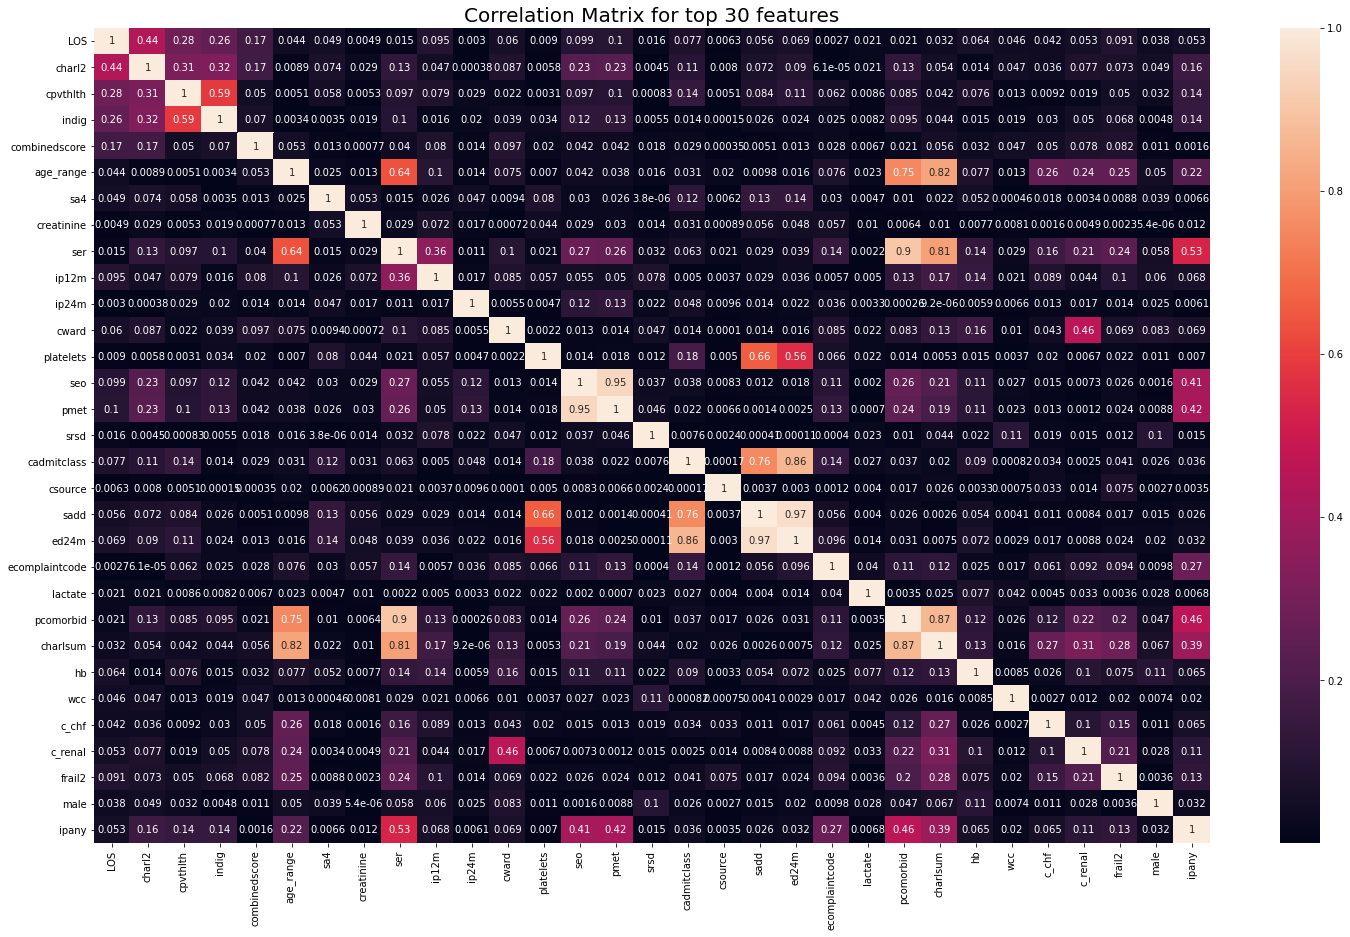

In [24]:
plt.figure(figsize=(25, 15))
sns.heatmap(T1.corr().abs(),  annot=True)
plt.title('Correlation Matrix for top 30 features', fontsize=20)
plt.show()

<div id="heading--3"/>

## 3. Evaluate Algorithms

<div id="heading--3-1"/>

### 3.1. split into train test sets

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.3, random_state=1)

print('Training samples: {}'.format(X_train.shape))
print('Testing samples:  {}'.format(X_test.shape))

Training samples: (468628, 43)
Testing samples:  (200841, 43)


<div id="heading--3-2"/>

### 3.2. Spot Check Algorithms

In [57]:
# Update encoder based on selected features
categorical_ix_new = [cat for cat in categorical_ix if cat in top_features]
Best_Enc = ColumnTransformer(transformers=[('cat',   TargetEncoder(smoothing=120,min_samples_leaf=18), categorical_ix_new )], remainder='passthrough') 
print(categorical_ix_new,categorical_ix)

['cward', 'csource', 'cadmitclass', 'ecomplaintcode', 'unitcode'] Index(['cward', 'csource', 'cadmitclass', 'ecomplaintcode', 'unitcode',
       'state'],
      dtype='object')


In [58]:
# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    alpha = [0.0, 0.1, 0.2]
    for a in alpha:
        models['lasso-'+str(a)] = Lasso(alpha=a)
    models['ridge-'] = Ridge()            
    models['en-'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    models['theil'] = TheilSenRegressor()
    # non-linear models
    n_neighbors = range(1, 3)
    for k in n_neighbors:
        models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k,n_jobs=-1)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    
    ''' takes too time so was commented
    models['svml'] = SVR(kernel='linear')
    models['svmp'] = SVR(kernel='poly')
    
    c_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    for c in c_values:
        models['svmr'+str(c)] = SVR(C=c)
    '''
    
    models['XGBR'] = XGBRegressor()
    # ensemble models
    n_trees = 500
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees,n_jobs=-1)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees,n_jobs=-1)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    #
    
    print('Defined %d models' % len(models))
    return models
    

In [59]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('Encoding', Best_Enc))
    # normalization
    steps.append(('standardize', Best_scaler))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [60]:
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=2, metric='neg_mean_absolute_error'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print('> %s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('> %s: error' % name)
    return results

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores
 


In [61]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,np.mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    
    for i in range(n):
        name = names[i]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()
    #plt.savefig('spotcheck.png')

Defined 23 models
> lr: -2.233 (+/-0.008)
> lasso-0.0: -2.233 (+/-0.008)
> lasso-0.1: -2.190 (+/-0.006)
> lasso-0.2: -2.190 (+/-0.006)
> ridge-: -2.233 (+/-0.008)
> en-: -2.467 (+/-0.005)
> huber: -1.943 (+/-0.006)
> lars: -2.233 (+/-0.008)
> llars: -3.460 (+/-0.002)
> pa: -3.447 (+/-0.125)
> ranscac: -3.556 (+/-0.068)
> sgd: -2.302 (+/-0.103)
> theil: error
> knn-1: -0.503 (+/-0.007)
> knn-2: -0.731 (+/-0.005)
> cart: -0.514 (+/-0.007)
> extra: -0.521 (+/-0.001)
> XGBR: -1.718 (+/-0.002)
> ada: -28.666 (+/-25.870)
> bag: -0.615 (+/-0.003)
> rf: -0.615 (+/-0.004)
> et: -0.405 (+/-0.001)
> gbm: -1.980 (+/-0.003)
Rank=1, Name=et, Score=-0.405 (+/- 0.001)
Rank=2, Name=knn-1, Score=-0.503 (+/- 0.007)
Rank=3, Name=cart, Score=-0.514 (+/- 0.007)
Rank=4, Name=extra, Score=-0.521 (+/- 0.001)
Rank=5, Name=bag, Score=-0.615 (+/- 0.003)
Rank=6, Name=rf, Score=-0.615 (+/- 0.004)
Rank=7, Name=knn-2, Score=-0.731 (+/- 0.005)
Rank=8, Name=XGBR, Score=-1.718 (+/- 0.002)
Rank=9, Name=huber, Score=-1.94

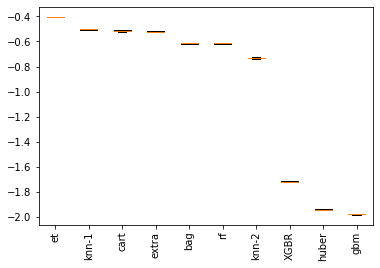

In [63]:

#print(categorical_ix_new,categorical_ix)
# get model list
models = get_models()
# evaluate models
results = evaluate_models(X_train,y_train, models, metric='neg_mean_absolute_error')
# summarize results
summarize_results(results)

<div id="heading--3-3"/>

### 3.3. Tuning Best models

<div id="heading--3-3-1"/>

### 3.3.1. Tuning KNN

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.3, random_state=42)

X_train_enc    = Best_Enc.fit_transform(X_train, y_train)
X_train_enc    = Best_scaler.fit_transform(X_train_enc)

X_test_enc    = Best_Enc.transform(X_test)
X_test_enc    = Best_scaler.transform(X_test_enc)
print('Training samples: {}'.format(X_train_enc.shape))
print('Testing samples:  {}'.format(X_test_enc.shape))

#encoder = CatBoostEncoder()
#encoder = LeaveOneOutEncoder()
#encoder =  MEstimateEncoder()
'''encoder = TargetEncoder()
X_train_enc    = encoder.fit_transform(X_train, y_train)
X_train_enc    = Best_scaler.fit_transform(X_train_enc)

X_test_enc    = encoder.transform(X_test)
X_test_enc    = Best_scaler.transform(X_test_enc)
print('Training samples: {}'.format(X_train_enc.shape))
print('Testing samples:  {}'.format(X_test_enc.shape))'''

Training samples: (468628, 43)
Testing samples:  (200841, 43)


"encoder = TargetEncoder()\nX_train_enc    = encoder.fit_transform(X_train, y_train)\nX_train_enc    = Best_scaler.fit_transform(X_train_enc)\n\nX_test_enc    = encoder.transform(X_test)\nX_test_enc    = Best_scaler.transform(X_test_enc)\nprint('Training samples: {}'.format(X_train_enc.shape))\nprint('Testing samples:  {}'.format(X_test_enc.shape))"

In [80]:
# defin model
model = KNeighborsRegressor(n_neighbors=1,n_jobs=-1)
#from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('columntransformer',Best_Enc),('t1', Best_scaler), ('model', model) ])
# define grid
grid = dict()
grid['model__weights'] =['uniform', 'distance']
# define search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error',verbose= 1,refit = True, cv=3, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)





Fitting 3 folds for each of 2 candidates, totalling 6 fits
MAE: -0.383
Config: {'model__weights': 'uniform'}


In [81]:
# prepare the model
model = KNeighborsRegressor(n_neighbors=1,weights=results.best_params_['model__weights'],n_jobs=-1)
# Fit regression model
print ('\nFit regression model...')
model.fit(X_train_enc, y_train)
y_train_pred = model.predict(X_train_enc)
print ('\ntransform the validation dataset')

y_test_pred  = model.predict(X_test_enc )


Fit regression model...

transform the validation dataset


MSE of train set: 0.68
MAE of train set: 0.06
R2  of train set: 0.98

MSE of test set: 3.13
MAE of test set: 0.24
R2  of test set: 0.92


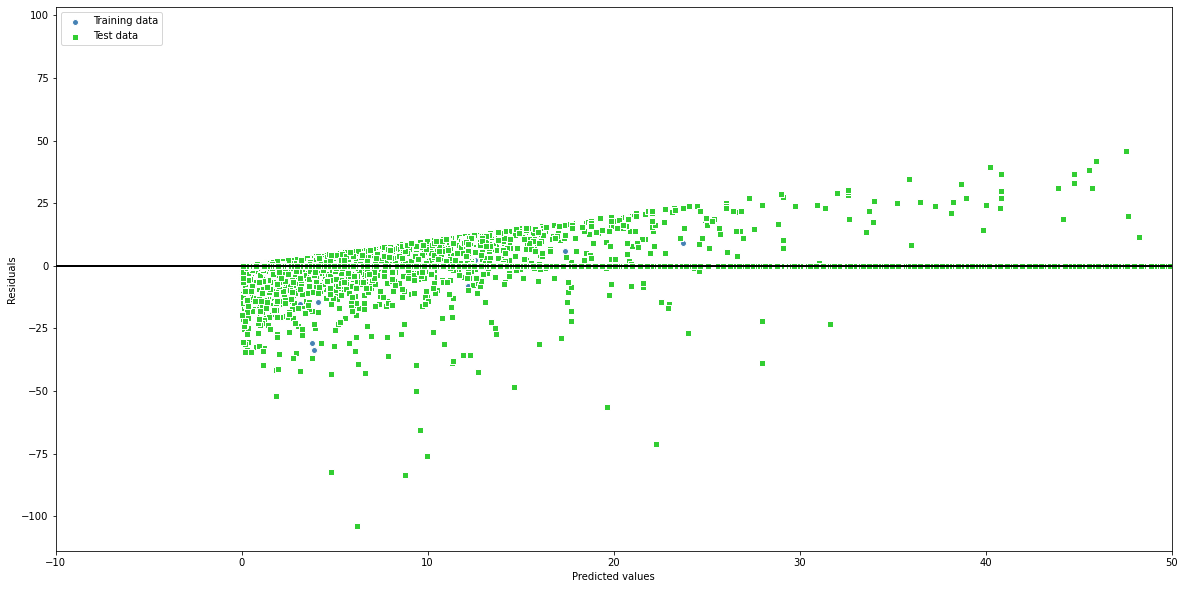

R^2 train: 0.984, test: 0.924


In [83]:

def residual_plot(y_train_pred, y_train, y_test_pred, y_test):
    plt.figure(figsize=(20, 10))
    plt.scatter(y_train_pred,  y_train_pred - y_train,c='steelblue', marker='o', 
                edgecolor='white',label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test,c='limegreen', marker='s', 
                edgecolor='white',label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
    plt.xlim([-10, 50])
    plt.show()
    print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                           r2_score(y_test, y_test_pred)))
print('MSE of train set: %.2f'
      % mean_squared_error(y_train, y_train_pred))
print('MAE of train set: %.2f'
      % mean_absolute_error(y_train, y_train_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2  of train set: %.2f'
      % r2_score(y_train, y_train_pred))

# transform the validation dataset


print('\nMSE of test set: %.2f'
      % mean_squared_error(y_test, y_test_pred))
print('MAE of test set: %.2f'
      % mean_absolute_error(y_test, y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2  of test set: %.2f'
      % r2_score(y_test, y_test_pred))
residual_plot(y_train_pred, y_train, y_test_pred, y_test)

In [84]:
n_features = X_train.shape[1]
n_samples = X_train.shape[0]

grid = GridSearchCV(ExtraTreeRegressor(random_state=1), cv=3, n_jobs=-1, verbose=5,
                    param_grid ={
                    'max_depth': [None],#,1,2,3,4,5,6,7],
                    'max_features': [None, 'sqrt', 'auto', 'log2', 0.3,0.5,0.7, n_features//2, n_features//3, ],
                    'min_samples_split': [2,0.3,0.5, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3,0.5, n_samples//2, n_samples//3, n_samples//5]
                    },
                    )

grid.fit(X_train_enc, y_train)
print('Train R^2 Score : %.3f'%grid.best_estimator_.score(X_train_enc, y_train))
print('Test R^2 Score : %.3f'%grid.best_estimator_.score(X_test_enc, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Train R^2 Score : 0.992
Test R^2 Score : 0.930
Best R^2 Score Through Grid Search : 0.868
Best Parameters :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}



Fit regression model...

transform the validation dataset
MSE of train set: 0.33
MAE of train set: 0.06
R2  of train set: 0.992

MSE of test set: 2.91
MAE of test set: 0.24
R2  of test set: 0.929


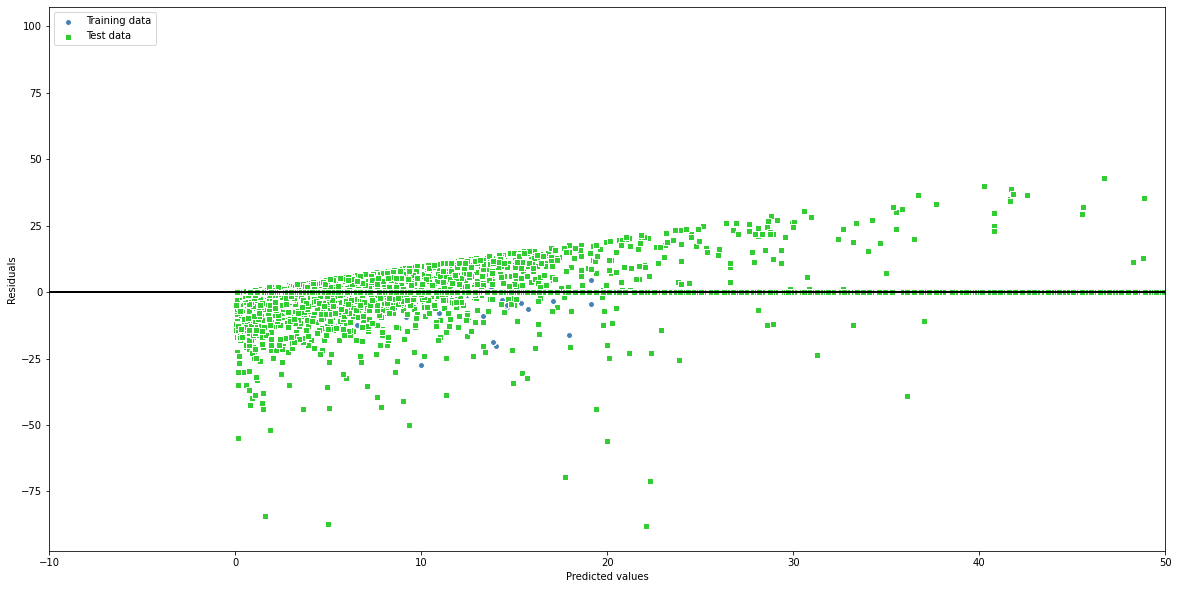

R^2 train: 0.992, test: 0.929


In [85]:
# prepare the model
#model = KNeighborsRegressor(n_neighbors=1,weights=results.best_params_['model__weights'],n_jobs=-1)
#model =  LinearRegression()
model = ExtraTreeRegressor(**grid.best_params_)
# Fit regression model
print ('\nFit regression model...')
model.fit(X_train_enc, y_train)
y_train_pred = model.predict(X_train_enc)
print ('\ntransform the validation dataset')

y_test_pred  = model.predict(X_test_enc )

print('MSE of train set: %.2f'
      % mean_squared_error(y_train, y_train_pred))
print('MAE of train set: %.2f'
      % mean_absolute_error(y_train, y_train_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2  of train set: %.3f'
      % r2_score(y_train, y_train_pred))

# transform the validation dataset


print('\nMSE of test set: %.2f'
      % mean_squared_error(y_test, y_test_pred))
print('MAE of test set: %.2f'
      % mean_absolute_error(y_test, y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2  of test set: %.3f'
      % r2_score(y_test, y_test_pred))
residual_plot(y_train_pred, y_train, y_test_pred, y_test)